In [70]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import seaborn as sns
sns.set_style("whitegrid")


In [102]:
df_main = pd.read_csv('Crawl/Data/Perfume_Data3.csv')
df_main.head()

,sothutu,Tên_Sản_Phẩm,Thương_Hiệu,Giá_Bán,Giá_Gốc,Dung_Tich,Phần_Trăm_Giảm
0,0,Nước Hoa Nữ Diamond Femme (Trắng),Eau De Parfum,301000,549000,45ml,45
1,1,Nước Hoa Vùng Kín Foellie Hương Hoa Hồng Mạnh Mẽ,Inner Perfume #Eau De Bijou,144000,350000,5ml,59
2,2,Nước Hoa Nữ Diamond Femme Pink (Hồng),Eau De Parfum,275000,549000,45ml,50
3,3,Nước Hoa Nam Diamond Homme (Đen),Eau De Parfum,275000,549000,45ml,50
4,4,Nước Hoa Nữ Diamond Femme Ruby Red (Đỏ),Eau De Parfum,301000,549000,45ml,45


In [103]:
# Thay thế NaN trong cột 'Thương_Hiệu' bằng 'Elite Perfume'
df_main['Thương_Hiệu'].fillna('Elite Perfume', inplace=True)
df_main = df_main.drop(columns=['Tên_Sản_Phẩm'])  # Loại bỏ các cột không cần thiết
X = df_main.drop(columns=['Giá_Bán'])  # Biến đầu vào
y = df_main['Giá_Bán']  # Biến mục tiêu

# Chuyển đổi các đơn vị thể tích từ ml thành số nếu cần
df_main['Dung_Tich'] = df_main['Dung_Tich'].str.replace('ml', '').astype(float)

# Xác định biến đầu vào và biến mục tiêu
X = df_main.drop(columns=['Giá_Bán'])
y = df_main['Giá_Bán']

# Chuyển đổi các biến phân loại thành biến số (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)


/tmp/ipykernel_5450/81388646.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_main['Thương_Hiệu'].fillna('Elite Perfume', inplace=True)


In [105]:
# Chuyển đổi các biến phân loại thành biến số (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

CV = []
R2_train = []
R2_test = []

In [94]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (850, 107)
X_test shape: (150, 107)
y_train shape: (850,)
y_test shape: (150,)


In [95]:
def perfume_pred_model(model, model_name):
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
            
    # R2 score của tập huấn luyện
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train, y_pred_train)
    R2_train.append(round(R2_train_model, 2))
    
    # R2 score của tập kiểm tra
    y_pred_test = model.predict(X_test)
    R2_test_model = r2_score(y_test, y_pred_test)
    R2_test.append(round(R2_test_model, 2))
    
    # R2 mean của tập huấn luyện sử dụng Cross validation
    cross_val = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cross_val.mean()
    CV.append(round(cv_mean, 2))
    
    # In kết quả
    print("Train R2-score:", round(R2_train_model, 2))
    print("Test R2-score:", round(R2_test_model, 2))
    print("Train CV scores:", cross_val)
    print("Train CV mean:", round(cv_mean, 2))
    
    # Vẽ đồ thị
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Residual Plot của dữ liệu huấn luyện
    ax[0].set_title('Residual Plot of Train samples')
    sns.distplot((y_train - y_pred_train), hist=False, ax=ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')
    
    # Đồ thị scatter giữa y_test và y_pred_test
    ax[1].set_title('y_test vs y_pred_test')
    ax[1].scatter(x=y_test, y=y_pred_test)
    ax[1].set_xlabel('y_test')
    ax[1].set_ylabel('y_pred_test')
    
    plt.show()



Train R2-score: 0.98
Test R2-score: 0.97
Train CV scores: [0.97275322 0.96223227 0.95911862 0.97213126 0.97790113]
Train CV mean: 0.97


/tmp/ipykernel_5450/850750115.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_pred_train), hist=False, ax=ax[0])


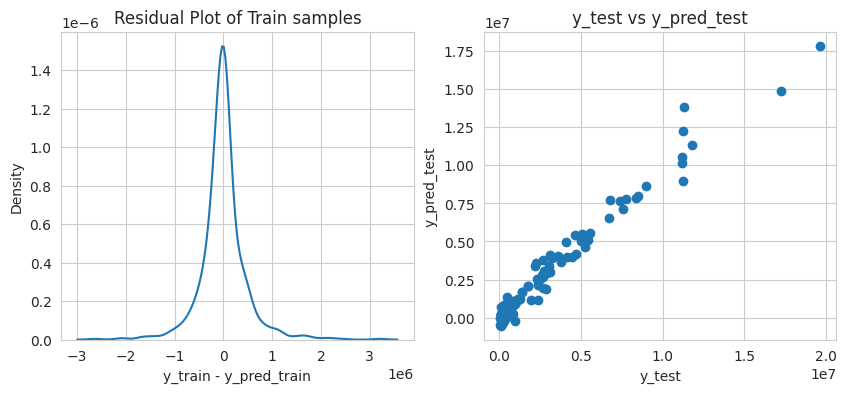

Mean Absolute Error: 329257.28766209853
Mean Squared Error: 304224874493.0772
Root Mean Squared Error: 551565.8387654888
     Giá_Ban_Dau   Gia_Du_Doan
521      1140000  1.214100e+06
737      9000000  8.610915e+06
740      4640000  5.413644e+06
660       656000  7.110415e+05
411       378000  2.751382e+05
..           ...           ...
914      8370000  7.818471e+06
810       176000 -3.369989e+05
244      4704000  4.184386e+06
822       730000  7.314822e+05
321       218000  1.776777e+05

[150 rows x 2 columns]


In [96]:
# Khởi tạo mô hình Linear Regression
linear_reg = LinearRegression()
perfume_pred_model(linear_reg, "linear.pkl")
# Huấn luyện mô hình
linear_reg.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_test = linear_reg.predict(X_test)

# Kiểm thử mô hình
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# So sánh giá ban đầu với giá mô hình dự đoán
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.92161e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.90747e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.2514e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.08749e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/sit

[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ...........................................alpha=10; total time=   0.0s[CV] END ...........................................alpha=10; total time=   0.0s

[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.44638e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.44638e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.92161e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Best parameters for Ridge Regression: {'alpha': 1}


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.90747e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.2514e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.08749e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.14845e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/tmp/ipykernel_5450/850750115.py:31: User

Train R2-score: 0.98
Test R2-score: 0.97
Train CV scores: [0.97527508 0.96483148 0.96861966 0.97141213 0.97663691]
Train CV mean: 0.97


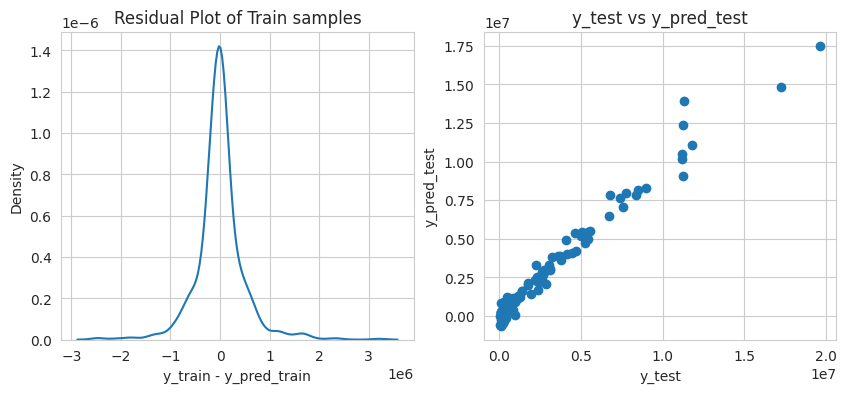

Mean Absolute Error: 322509.3940537273
Mean Squared Error: 286037048353.8059
Root Mean Squared Error: 534824.3154100288
     Giá_Ban_Dau   Gia_Du_Doan
521      1140000  1.298111e+06
737      9000000  8.294684e+06
740      4640000  5.363543e+06
660       656000  6.260118e+05
411       378000  2.595448e+05
..           ...           ...
914      8370000  7.839962e+06
810       176000 -4.529272e+05
244      4704000  4.203738e+06
822       730000  7.017570e+05
321       218000  1.769007e+05

[150 rows x 2 columns]


In [97]:
# Khởi tạo mô hình Ridge Regression
ridge_reg = Ridge()
# Thiết lập các tham số cần tìm kiếm
param_grid_ridge = {'alpha': [0.1, 1, 10, 100]}

# Grid search với cross-validation
grid_search_ridge = GridSearchCV(estimator=ridge_reg, param_grid=param_grid_ridge, cv=5, n_jobs=-1, verbose=2)
grid_search_ridge.fit(X_train, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters for Ridge Regression: {grid_search_ridge.best_params_}")

# Sử dụng mô hình tốt nhất để dự đoán
best_ridge = grid_search_ridge.best_estimator_
y_pred_test = best_ridge.predict(X_test)
perfume_pred_model(ridge_reg, "ridge.pkl")
# Kiểm thử mô hình
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# So sánh giá ban đầu với giá mô hình dự đoán
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estim

/tmp/ipykernel_5450/850750115.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_pred_train), hist=False, ax=ax[0])


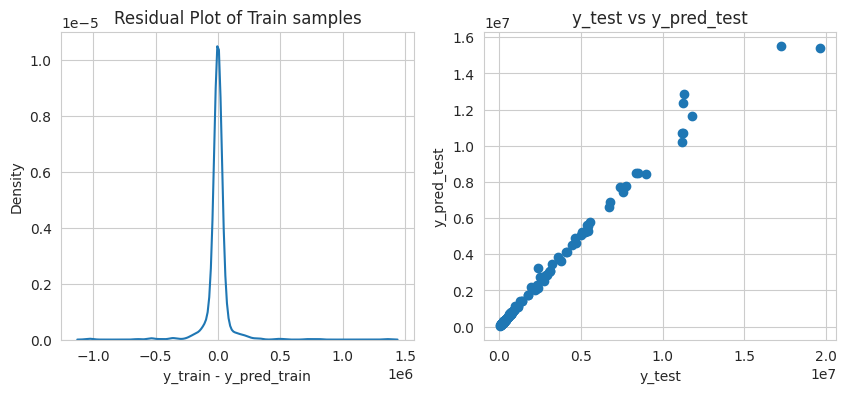

Mean Absolute Error: 322509.3940537273
Mean Squared Error: 286037048353.8059
Root Mean Squared Error: 534824.3154100288
     Giá_Ban_Dau  Gia_Du_Doan
521      1140000    1099435.0
737      9000000    8426495.0
740      4640000    4875800.0
660       656000     664580.0
411       378000     382855.0
..           ...          ...
914      8370000    8465660.0
810       176000     202670.0
244      4704000    4620180.0
822       730000     685590.0
321       218000     218040.0

[150 rows x 2 columns]


In [98]:
# Khởi tạo mô hình Random Forest
rf = RandomForestRegressor(random_state=42)

# Thiết lập các tham số cần tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search với cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Huấn luyện mô hình
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters: {grid_search.best_params_}")

# Sử dụng mô hình tốt nhất để dự đoán
best_rf = grid_search.best_estimator_
perfume_pred_model(best_rf, "RandomForest_regressor.pkl")

# Kiểm thử mô hình
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# So sánh giá ban đầu với giá mô hình dự đoán
y_pred_test = best_rf.predict(X_test)
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=

/tmp/ipykernel_5450/850750115.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_pred_train), hist=False, ax=ax[0])


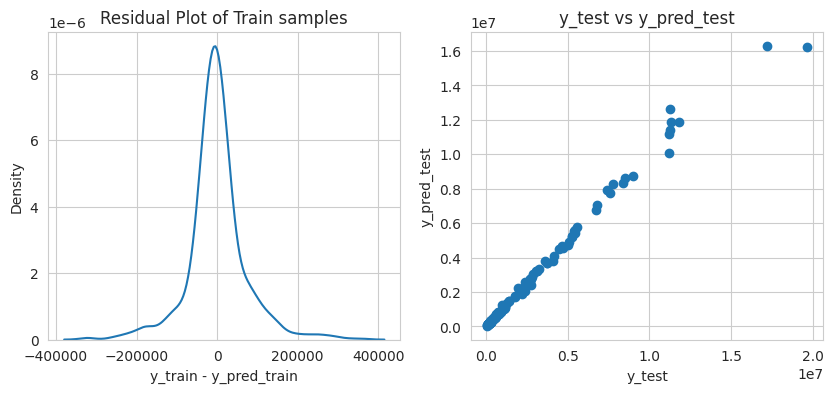

Mean Absolute Error: 102139.90608994625
Mean Squared Error: 111168110051.02565
Root Mean Squared Error: 333418.82078104955
     Giá_Ban_Dau   Gia_Du_Doan
521      1140000  1.092913e+06
737      9000000  8.791142e+06
740      4640000  4.640985e+06
660       656000  6.837995e+05
411       378000  3.697553e+05
..           ...           ...
914      8370000  8.323607e+06
810       176000  1.866800e+05
244      4704000  4.552651e+06
822       730000  7.151020e+05
321       218000  2.314101e+05

[150 rows x 2 columns]


In [99]:
# Khởi tạo mô hình Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
# Thiết lập các tham số cần tìm kiếm
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search với cross-validation
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=5, n_jobs=-1, verbose=2)
grid_search_gbr.fit(X_train, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters for Gradient Boosting Regressor: {grid_search_gbr.best_params_}")

# Sử dụng mô hình tốt nhất để dự đoán
best_gbr = grid_search_gbr.best_estimator_
y_pred_test = best_gbr.predict(X_test)
perfume_pred_model(gbr, "gbr.pkl")
# Kiểm thử mô hình
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# So sánh giá ban đầu với giá mô hình dự đoán
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)

In [100]:
# Tổng hợp kết quả
Technique = ["Linear Regression", "Ridge Regression", "Random Forest", "Gradient Boosting"]
results = pd.DataFrame({
    'Model': Technique,
    'R Squared(Train)': R2_train,
    'R Squared(Test)': R2_test,
    'CV score mean(Train)': CV
})
display(results)

,Model,R Squared(Train),R Squared(Test),CV score mean(Train)
0,Linear Regression,0.98,0.97,0.97
1,Ridge Regression,0.98,0.97,0.97
2,Random Forest,1.00,0.98,0.99
3,Gradient Boosting,1.00,0.99,0.99
